La idea es calcular los parámetros de R1 de manera alternativa. Como en el paso 5 de la calibración rotamos R2 y P2, basicamente estamos haciendo un análisis del vector de Stokes producido por el generador de estados (al que pertenece R1). COmo todo lo demás ya está calibrado, vamos a calcular R1 a partid de este método en lugar del genérico, a ver si da mejor resultado.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget

In [2]:
import numpy as np
from py_pol.mueller import Mueller, degrees
from py_pol.stokes import Stokes
from polaripython.utils import plot_experiment_residuals_2D, limit_pes
from scipy.optimize import leastsq
import os

Usar los datos para el resto de parametros obtenidos en la calibracion.

In [3]:
vector = np.transpose(np.matrix([+5.302, -0.459, -0.064, +5.226]))
Sillum = Stokes('Sillum')
Sillum.from_matrix(vector)

p11 = 1.002
p12 = -0.085
th0p1 = -40.9*degrees
p21 = 0.998
p22 = -0.028
th0p2 = 31.5*degrees
Mp2 = Mueller('Mp1')
Mp2.diattenuator_linear(p21, p22, th0p2)

R2p1 = 1
R2p2 = 1
Dr2 = 83.4*degrees
th0r2 = 129.6*degrees
Dp1 = 91*degrees
Mr2 = Mueller('Mr2')
Mr2.diattenuator_retarder_linear(R2p1, R2p2, Dr2, th0r2)
Mp1 = Mueller('Mp1')
Mp1.diattenuator_retarder_linear(p11, p12, Dp1, th0p1)


matrix([[ 0.5056145 ,  0.07108476, -0.49329408,  0.        ],
        [ 0.07108476,  0.01174191, -0.07116813, -0.0842864 ],
        [-0.49329408, -0.07116813,  0.49535902, -0.01214586],
        [ 0.        ,  0.0842864 ,  0.01214586,  0.00148642]])

Cargar los datos experimentales

In [4]:
folder = r'D:\Codigo_UCM\polaripython\calibration\Calibration_2019-07-15'
os.chdir(folder)
file = '2019-07-15'
filename = 'Step_5b_' + file + '.npz'
data = np.load(filename, encoding='latin1')
Iexp = data["IexpC"]
ax = data["angles2x"]
ay = data["angles2y"]

Al igual que en el caso del polarimetro, se puede calcular el vector de Stokes calculando una matriz pseudoinversa. 

In [5]:
# Calcular la matriz de elementos del analizador para cada medida
N1 = ax.size
N2 = ay.size
N = N1 * N2
total = [N1, N2]
A = np.zeros([N,4])
for indX in range(N1):
    Mr2_rotated = Mr2.rotate(ax[indX], keep=True)
    for indY in range(N2):
        ind = np.ravel_multi_index([indX, indY], total)
        Mp1_rotated = Mp1.rotate(ay[indY], keep=True)
        A_measure = Mp1_rotated * Mr2_rotated
        A[ind, :] = A_measure.M[0,:]  

In [6]:
# Calcular la matriz pseudoinversa, el vector de Stokes del generador y la matriz de Mueller del retardador 1
print(A.shape)
At = np.transpose(A)
aux = At @ A
aux_inv = np.linalg.inv(aux)
Ai = aux_inv @ At
Ivector = Iexp.flatten()
Sexp_vect = Ai @ Ivector
Sexp = Stokes('G')
Sexp.from_matrix(np.matrix(Sexp_vect).T)
print(Sexp)
# print(Sexp.M)

# Ai2 = np.linalg.pinv(A)
# Sexp2_vect = Ai2 @ Ivector
# Sexp2 = Stokes('G')
# Sexp2.from_matrix(np.matrix(Sexp2_vect).T)
# print(Sexp2)
# print(Sexp2.M)

(225, 4)
G = [+2.553; -0.627; +0.154; -1.853]

[[ 2.55321276]
 [-0.62674753]
 [ 0.15403059]
 [-1.85350416]]
G = [+2.553; -0.627; +0.154; -1.853]

[[ 2.55321276]
 [-0.62674753]
 [ 0.15403059]
 [-1.85350416]]


Vamos a comprobar si el resultado es correcto repitiendo el experto simuladamente y comparando con el experimento.

The normalized MSE is: 1.42 %


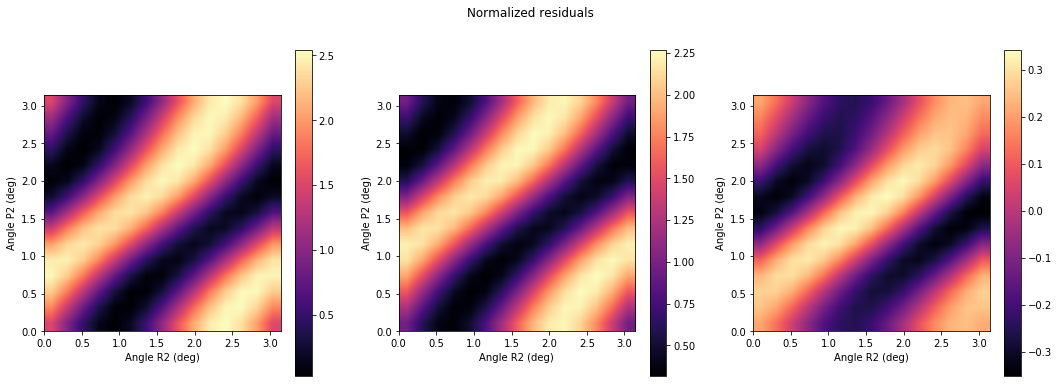

In [7]:
Icheck = np.zeros([N1,N2])
for indX in range(N1):
    Mr2_rotated = Mr2.rotate(ax[indX], keep=True)
    for indY in range(N2):
        Mp1_rotated = Mp1.rotate(ay[indY], keep=True)
        S_measure = Mp1_rotated * Mr2_rotated * Sexp
        Icheck[indX, indY] = S_measure.parameters.intensity()
plot_experiment_residuals_2D(ax, ay, Iexp, Icheck, title='Comparacion', xlabel='Angle R2 (deg)', ylabel='Angle P2 (deg)')

Calculemos la matriz del retardador 2 y sus parametros

In [8]:
print(Sillum.M)
print(Sillum.pseudoinverse(keep=True, returns_matrix=True))
print(Sillum.pseudoinverse(keep=True, returns_matrix=True) * Sillum.M)
Mr1 = (Sexp.M * Sillum.pseudoinverse(keep=True, returns_matrix=True)) * Mp1.inverse(keep=True, returns_matrix=True)
print(Mr1)

[[ 5.302]
 [-0.459]
 [-0.064]
 [ 5.226]]
[[ 0.0952962  -0.0082499  -0.00115031  0.0939302 ]]
[[1.]]
[[ 1.69660220e+01 -5.17621986e+00  1.61506193e+01 -2.00523080e-01]
 [-4.16471847e+00  1.27062776e+00 -3.96455825e+00  4.92232166e-02]
 [ 1.02352864e+00 -3.12271744e-01  9.74336905e-01 -1.20971855e-02]
 [-1.23164794e+01  3.75767551e+00 -1.17245380e+01  1.45569679e-01]]


No funciona por tener que calcular el pseudoinverso de un vector de Stokes. 

Si lo pensamos de otra manera, tenemos un vector de 4 elementos conocido, y queremos calcular una matriz de Mueller de 16 elementos que corresponde al retardador. Eso podría hacer que pareciera que tenemos menos ecuaciones que incognitas. Pero nuestro retardador viene dado por 4 parámetros, por lo que se puede hacer un proceso de ajuste.

In [14]:
# Funcion para ajustar
def modelo(par):
    par[0], par[1] = limit_pes(par[0:2])
    Mr1 = Mueller()
    Mr1.diattenuator_retarder_linear(par[0], par[1], par[2], par[3])
    Sgen = Mr1 * Mp1 * Sillum
    return Sgen

def error(par, Sexp):
    Smodel = modelo(par)
    dif = np.array(Sexp.M - Smodel.M).flatten()
    return dif

In [20]:
r = np.random.rand(1) * np.pi
par0 = [0.9, 0.9, 82.9*degrees, r[0]]
par1, success = leastsq(error, par0, args=(Sexp))
par1[0], par1[1] = limit_pes(par1[0:2])
par1[2] = par1[2] % np.pi
par1[3] = par1[3] % np.pi
Smod = modelo(par1)
dif = error(par1, Sexp)
err = np.linalg.norm(dif) / np.linalg.norm(Sexp.M)

print("Step 5 results:")
print(" - Sexp:")
print(Sexp)
print(" - Smodel:")
print(Smod)
print(" - Difference:")
print(dif)

print("\n")
print("Step 5 parameters:")
print("  - P1           = {:.3f};".format(par1[0]))
print("  - P2           = {:.3f};".format(par1[1]))
print("  - Retardance   = {:.1f} deg;".format(par1[2] / degrees))
print("  - R1 reference angle      = {:.1f} deg;".format(par1[3] / degrees))
print("  - Error        = {:.1f} %;".format(err*100))

Step 5 results:
 - Sexp:
G = [+2.553; -0.627; +0.154; -1.853]

 - Smodel:
M @7.66 deg * Mp1 @-40.90 deg * Sillum = [+2.680; -0.629; -0.617; +2.530]

 - Difference:
[-1.26498229e-01  2.21094108e-03  7.70841440e-01 -4.38343707e+00]


Step 5 parameters:
  - P1           = 1.000;
  - P2           = 1.000;
  - Retardance   = 81.1 deg;
  - R1 reference angle      = 7.7 deg;
  - Error        = 138.3 %;


No hay manera de obtener un minimo absoluto, la funcion de optimizacion cae siempre en minimos locales, por lo que no sirve para nada.